In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import csv
from keras.callbacks import History
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Input
# import tensorflow as tf
# print(tf.__file__)
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

plt.rcParams["axes.unicode_minus"]=False


In [106]:
def generate_diff(input_array):
    output_array = [0]  # 初始值设为0
    
    for i in range(1, len(input_array)):
        output_array.append(input_array[i] - input_array[i - 1])
        
    return output_array
    
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

dataset = read_csv('2012-2016.csv',  parse_dates = ['Date'], date_parser=parse)
dataset = dataset = dataset.drop(columns=['Time'])
dataset.dropna()
dataset['Diff'] = dataset['Close'].diff()

###### 新的一天，将diff设置为0
dataset.loc[dataset['Date'] != dataset['Date'].shift(), 'Diff'] = 0
#######
dataset.set_index('Date', inplace=True)
# MA

# summarize first 5 rows
print(dataset[298:305])#檢查患日有沒有diff規0
print(dataset.head(5))
# print(dataset.tail())
print(dataset.shape)
# # save to file
# dataset.to_csv('Q1_dataset.csv')

C:\Users\losyo\AppData\Local\Temp\ipykernel_6488\2469833225.py:13: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  dataset = read_csv('2012-2016.csv',  parse_dates = ['Date'], date_parser=parse)


NameError: name 'df' is not defined

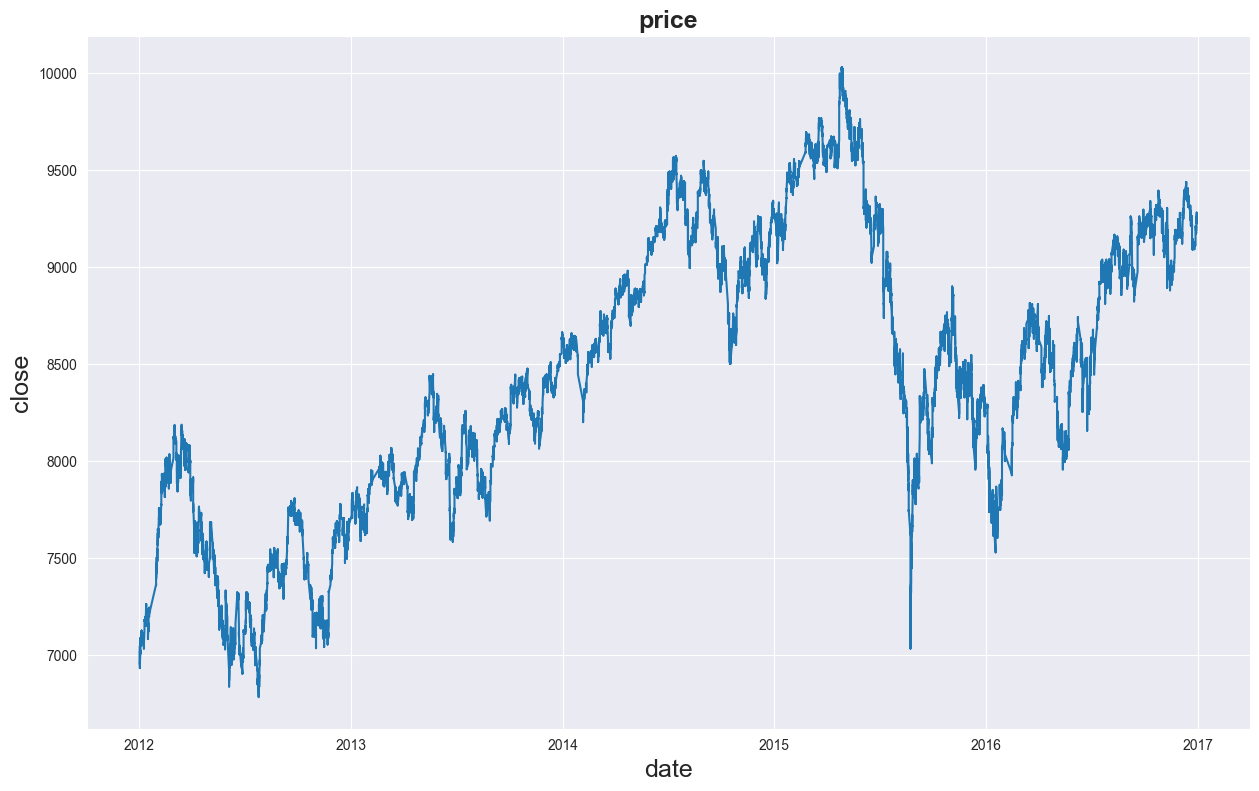

In [100]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(dataset.index,dataset[['Close']])
# plt.xticks(range(0,dataset.shape[0], 10000), dataset.index[::10000],rotation=45)
plt.title("price", fontsize=18, fontweight='bold')
plt.xlabel("date", fontsize=18)
plt.ylabel("close", fontsize=18)
plt.show()

In [102]:
def generate_y_for10(input_array):
    output_array = [] 
    
    for i in range(0, len(input_array)):
        if input_array[i]>0:
            output_array.append(2)
        elif input_array[i]<0:
            output_array.append(1)
        else:
            output_array.append(0)
    
    return output_array
    

values = dataset.values
# ensure all data is float
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
#############################################
# scaler_diff=MinMaxScaler(feature_range=(-1,1))
# t=scaler_diff.fit_transform(values[:,-1].reshape(-1,1))
# print(t)
#############################################
# normalize features
scaled = scaler.fit_transform(values)#待檢查
print(scaled)

# y_label = scaled[:,-2] #close為label

##漲跌平
class_indices= generate_y_for10(values[:,5]) #diff
# 确定类别的数量
num_classes = max(class_indices) + 1

# 使用NumPy创建一个全零数组，形状为(数组长度, 类别数量)
y_label = np.zeros((len(class_indices), num_classes))
# 将对应的位置设置为1
y_label[np.arange(len(class_indices)), class_indices] = 1

print(y_label[:5])
##

# 新增一列(diff 正規過後)
diff_n= np.array(generate_diff(scaled[:,3]))#close
# 创建布尔掩码
mask = values[:,5] == 0.0
# 使用布尔掩码将 b 中对应位置的值设为 0
diff_n[mask] = 0.0
x_label=np.hstack((scaled[:,[0,1,2,3,4]], diff_n.reshape(-1, 1)))
# x_label=np.hstack((x_label,np.array(generate_diff(scaled[:,6])).reshape(-1, 1)))
###########################
# x_label=x_label[:,[0,1,2,3,4,6]] #不要MA
# x_label=x_label[:,[0,1,2,3,5,6]]#不要total volume
# x_label=values
# csv_file_name = "output_array.csv"
# # 将NumPy数组写入CSV文件
# with open(csv_file_name, 'w', newline='') as csvfile:
#     csv_writer = csv.writer(csvfile)
#     csv_writer.writerows(x_label)
print(x_label[298:305])

[[0.0744617  0.07538462 0.07263756 0.07323074 0.11741385 0.6691176 ]
 [0.07323074 0.07261539 0.0710988  0.07015395 0.06922843 0.63235295]
 [0.07015395 0.06984615 0.07079101 0.07015395 0.0529633  0.6691176 ]
 ...
 [0.7633846  0.7630768  0.7651584  0.7636924  0.06821185 0.6727941 ]
 [0.7633846  0.7630768  0.7651584  0.7633846  0.06556877 0.66544116]
 [0.76399994 0.7633846  0.7651584  0.7636924  0.10643489 0.6727941 ]]
[[1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]
[[ 0.04584622  0.04984617  0.04739904  0.05015397  0.12991767  0.00399995]
 [ 0.04984617  0.05138469  0.05140042  0.05200005  0.13540713  0.00184608]
 [ 0.0738461   0.07569218  0.07540774  0.0744617   0.1943682   0.        ]
 [ 0.07476926  0.07446146  0.07509995  0.0741539   0.07085494 -0.0003078 ]
 [ 0.0744617   0.0741539   0.07540774  0.07476926  0.03771475  0.00061536]
 [ 0.07476926  0.0738461   0.07540774  0.07476926  0.03761309  0.        ]
 [ 0.0744617   0.0738461   0.07448435  0.0738461   0.04432246 -0.0009

In [103]:
def split_windows(data,label, seq_length):
    x=[]
    y=[]
    for i in range(len(data)-seq_length-1):
        _x=data[i:(i+seq_length),:]
        _y=label[i+seq_length]
        x.append(_x)
        y.append(_y)
    x,y=np.array(x),np.array(y)
    # print('x.shape,y.shape=\n',x.shape,y.shape)
    return x,y

def split_data(x, y, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_ratio, shuffle=False)
    return x_train, y_train, x_test, y_test



In [104]:
windowed_x, windowed_y = split_windows(x_label, y_label, 6) ##特徵序列長度#middle
print(windowed_x.shape, windowed_y.shape)

(368684, 6, 6) (368684, 3)


In [105]:
x_train, y_train, x_test, y_test = split_data(windowed_x, windowed_y, 0.2)#數據集分割 #paper test為2016年, 大概20%?
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(294947, 6, 6) (294947, 3)
(73737, 6, 6) (73737, 3)


In [94]:
model=Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(x_train.shape[1],32),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_initializer='normal'))
model.add(Dense(3, activation='softmax', kernel_initializer='normal'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
history=model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), batch_size=300, verbose=1)

Epoch 1/50
984/984 [==============================] - 36s 33ms/step - loss: 1.0540 - accuracy: 0.3972 - val_loss: 1.0347 - val_accuracy: 0.4078
Epoch 2/50
984/984 [==============================] - 31s 31ms/step - loss: 1.0467 - accuracy: 0.3987 - val_loss: 1.0332 - val_accuracy: 0.4101
Epoch 3/50
984/984 [==============================] - 31s 32ms/step - loss: 1.0456 - accuracy: 0.3998 - val_loss: 1.0326 - val_accuracy: 0.4054
Epoch 4/50
984/984 [==============================] - 31s 31ms/step - loss: 1.0449 - accuracy: 0.3993 - val_loss: 1.0334 - val_accuracy: 0.4063
Epoch 5/50
984/984 [==============================] - 30s 30ms/step - loss: 1.0447 - accuracy: 0.3983 - val_loss: 1.0319 - val_accuracy: 0.4101
Epoch 6/50
984/984 [==============================] - 29s 30ms/step - loss: 1.0444 - accuracy: 0.3987 - val_loss: 1.0317 - val_accuracy: 0.4101
Epoch 7/50
984/984 [==============================] - 29s 30ms/step - loss: 1.0443 - accuracy: 0.4003 - val_loss: 1.0319 - val_accuracy:

KeyboardInterrupt: 

In [95]:
model.summary()



Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 6, 32)             5120      
                                                                 
 dropout_12 (Dropout)        (None, 6, 32)             0         
                                                                 
 lstm_13 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 3)                 99        
                                                                 
Total params: 14595 (57.01 KB)
Trainable params: 14595

In [96]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

2305/2305 [==============================] - 5s 2ms/step


In [97]:

test_predict_argmax = np.argmax(test_predict, axis=1)
# 将真实标签转换为真实的类别索引
y_test_argmax = np.argmax(y_test, axis=1)
# 计算准确率
accuracy = np.mean(y_test_argmax == test_predict_argmax)
print("Accuracy test:", accuracy)


train_predict_argmax = np.argmax(train_predict, axis=1)
# 将真实标签转换为真实的类别索引
y_train_argmax = np.argmax(y_train, axis=1)
# 计算准确率
accuracy = np.mean(y_train_argmax == train_predict_argmax)
print("Accuracy train:", accuracy)


idx_l=[]
for idx, value in enumerate(test_predict_argmax):
    if value == 0:
        idx_l.append(idx)

# print(idx_l)
idx_ll=[]
for idx, value in enumerate(y_test_argmax):
    if value == 0:
        idx_ll.append(idx)

print(len(idx_l),len(idx_ll))

# ##drop 0.2 兩次 step=6
# Accuracy test: 0.4081939867366451
# Accuracy train: 0.40397766378366284

##drop 0.2 1次

Accuracy test: 0.4055875771343324
Accuracy train: 0.4022953821116159
5324 14235


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


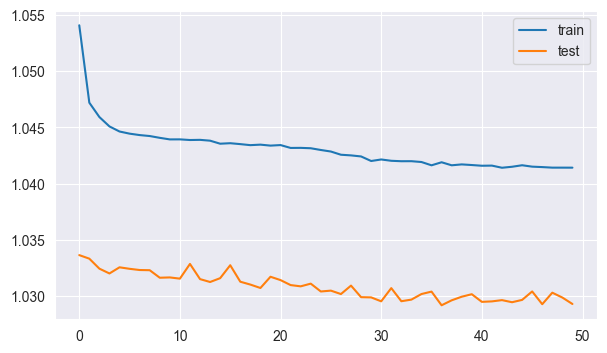

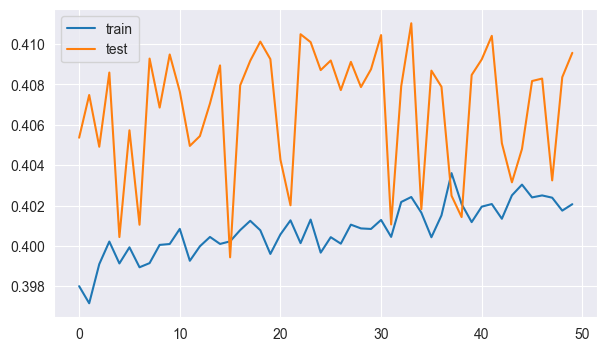

In [98]:
print(history.history.keys())
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']  # 可以指定多个字体备选
plt.rcParams['axes.unicode_minus'] = False  # 用于解决负号显示问题
# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

